*March 2020*
Representation and Interaction

## Multiagent search of lost targets 2D in a static world using range sensors

**Author**: Pablo Lanillos Donders Institute

**References**: 
- Lanillos, P. (2013): Minimum time search of moving targets in uncertain environments. Ph.D. Dissertation. url: 
http://www.therobotdecision.com/papers/PhD_MinimumTimeSearch_2013_FinalElectronic_English_PabloLanillos.pdf

*Continuous*
- Lanillos, P., Gan, S. K., Besada-Portas, E., Pajares, G., & Sukkarieh, S. (2014). Multi-UAV target search using decentralized gradient-based negotiation with expected observation. Information Sciences, 282, 92-110.

*Discrete*
- Lanillos, P., Besada-Portas, E., Pajares, G., & Ruz, J. J. (2012, October). Minimum time search for lost targets using cross entropy optimization. In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems (pp. 602-609). IEEE.

All references can be found in Brightspace

### A small introduction tale
There  is  no  doubt, I  have lost my keys again, I’m late and I don’t know where to start the search. I evaluate the alternatives.  I usually leave them at the entrance hall, hanging from that screw that I put in a provisional eternal way.  They can also be in the bedroom, inside the Cairo bowl or inside the jeans pocket, which I have used yesterday.  Rationally, the most coherent action is to look first at the hall, but in the case that the keys are not there, I have to come back and that is a great time-wasting.  I only have ten minutes left to pick up the high speed train to Barcelona.  Therefore, I finally decide to watch in the bowl first and afterwards inside the jeans, and if I don’t find them I will look at the screw, which is on my way out. 
<img src="img/irritated-man-on-a-train.png" width="200" style="float: right;" />



Already  heading  Barcelona,  inside  the  train  and  without  the  keys,  I  think  about  my decision.  I really don’t know if my searching strategy has been optimal. Served with a coffee at the dining car, I write down the different options that I had this morning to prove that I have made the correct decision.  The problem started with the subjective information about the keys location: high  probability  of  finding  them  at  the  hall  and  medium  probability  of  finding  them in  the  jeans  and  the  bowl.   If  I  can  quantify  that  information,  the  only  thing  I  have to  determine  is  which  searching  path  is  the  best.   Thus,  I  need  the  actions  sequence that gives maximum probability of finding the keys, which is the same to look for the sequence that gives minimum probability of not finding them.  I raise my gaze and I take pleasure of my own explanation.  

The train car is getting full of people, maybe because it is lunch time. I stare again at my sheet full of hieroglyph and I continue engrossed in my task.  After doing some math, I check that ordering the places from greater to less probability and visiting them according to that order could be the best strategy. While I bite my green pen with anxiety, I discover that the method doesn’t always work and more questions arrive without an answer:  What happens if the time is critical? What if we are several people? And what about if already choosing a decision the alternatives change?...  But the fact that make me  feel  unease  is  to  think  that  even  making  the  right  decisions,  why  haven’t I found the keys? Once in  my  seat,  with  the  eyes  wide  shut  and  a  little  bit  sleepy,  I  receive  a  message on my cellphone that says:  - *remember that I took the keys to water the plants. When you come back, please call me.  Kisses* -.

### Description of the problem

<img src="img/problem-definition.png" width="400" style="float: left;" />
There is a shipwreck alert. We need to find the survivors but we do not have so much time. We count with a fleet of Unmanned Air Vehicles (UAVs) with sensors on board. We also have an initial guess of the possible areas where the survivors can be, such as a probability of finding the survivors. For simplicity we are going to do a strong assumption: the location of the survivors is constant. In other words, the world is static or the targets (survivors) do not have dynamics.

**The goal of this assignment is to program an algorithm that let multiple searching agents to find the survivors as soon as possible.** In other words, the algorithm should compute the optimal actions for the UAVs.

<img src="img/shipwreck.png" width="600" />

This document will drive you through the assignment composed of the following sections:

*In this booknote*
1. Modelling the problem: environment, agent and sensor
2. One agent search greedy 1 step discrete

*In the next booknote*
3. Multiagent search greedy 1 step discrete no communication
4. Multiagent search greedy 1 step discrete common belief
5. Multiagent search n-step continuous optimization (centralized)

### Import needed libraries

In [31]:
# Numpy numerical library -> import [library] as name
import numpy as np

# Plotting libraries -> matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # 3D plots
from matplotlib import cm # Color maps

# Matrix auxiliary functions
import numpy.matlib

# System libraries
import os
import sys
import math

### 1. Modelling the problem: environment, sensor and agents

#### Environment
We model the environment as bounded 2D space of width $w$ and height $h$. The discrete representation of the world can be stored in a matrix that looks like:

<img src="img/map.png" width="400" />


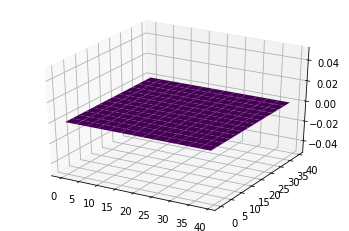

In [65]:
# Plot the discrete environment
from itertools import permutations
width = height = 40 # Size of the environment

x = y = np.arange(width) # This only works if both have the same size
X, Y = np.meshgrid(x, y) # generate grid

map = np.zeros((width,height))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, map, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
# Write your code here for ploting the map using plot_surface (see 1_python_numpy_basics notebook)

#### Sensor
Each agent $i$ has a range sensor on board able to detect people in the sea with probability $p$. The position of the agent  is $x=\{x_i,x_j\}$ (2D location). We are going to model the sensor in a probabilistic fashion. The sensor will return the probability of non-detecting the target. This is due to the utility function that we will see afterwards. Given the euclidean distance between the agent and the potential target location as $d$, the range sensor is modelled by the following equation:

$$p(\overline{D}) = 1 - P_{d_{max}} \exp\left[ -\sigma \left( \frac{d}{d_{max}}\right)^2 \right]$$

Note that we can compute the euclidian distance as $d = \sqrt{ (i-x_i)^2 +(j-x_j)^2}$ and $\exp$ is the exponential operator. 

Program and plot the non-detection sensor model. The plot should looks like this one:
<img src="img/pnd-sensor.png" width="400" />

Note that we can update the belief that the agent has about the world with observations using a Recursive Bayesian Estimator procedure. Here as the world is static we only need the update and not the prediction step.

The update for $N$ observations (N steps ahead) is as follows: 

$$ b^k = \prod_{j=1}^N P(\overline{D}|x^k, \tau) b^{k-1} $$
Where $b^{k-1}$ is our prior belief of the target location $P(\tau)$ and $N$ is the number of observations. Here, we are assuming independence of the measures (observations).

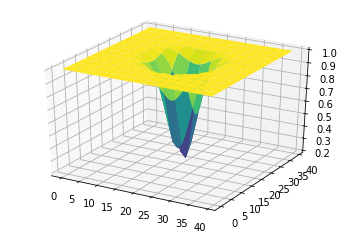

In [33]:
# observation model
Pdmax = 0.8 # Max range sensor
dmax = 4 # Max distance
sigma = 0.7 # Sensor spread (standard deviation)

x = [20,20] # Agent 2D location 
I = X.flatten() # Convert matrix into a single vector useful for operating 
J = Y.flatten() # Convert matrix into a single vector useful for operating 

## Write your code here
# Compute the sensor P(\overline{D}) with a function with name 
# def sensor_pnd( ... ):
def sensor_pnd(pdmax, dmax, sigma, x, i, j):
    d = math.sqrt(math.pow((i - x[0]), 2) + math.pow((j - x[1]), 2))
    thing = pdmax * math.exp(-sigma * math.pow(d/dmax, 2))
    pnd = 1 - thing
    return pnd

# Plot the sensor
map = np.zeros((width, height))
for i in I:
    for list in Y:
        j = list[0]
        distance = sensor_pnd(Pdmax, dmax, sigma, x, i, j)
        map[i][j] = distance

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, map, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

#### Agents
Each agent in the discrete version has its state defined as the 2D location $s$ at time $k$ ($s^k$) and a set of possible actions $u^k$. The grid and the possible actions are defined in the following figure:
<img src="img/actions-discrete.png" width="400" />

In [34]:
ndir = 9 # number of movements
delta = 0.5 # Constant displacement
# Define the 9 possible movements with an array of size(ndir,2) of delta increments
# Example to move up is -delta, 0

# Write your code here
# mat = np.array([[-0.5, -0.5], [-0.5, 0.], [-0.5, 0.5], [0., -0.5], [0., 0.], [0., 0.5], [0.5, -0.5], [0.5, 0.], [0.5, 0.5]])
mat = np.array([[-1., -1.], [-1., 0.], [-1., 1.], [0., -1.], [0., 0.], [0., 1.], [1., -1.], [1., 0.], [1., 1.]])

print("Movements", mat)


# Given the state of the agent
x = [20,20] # agent state

# Write a function that computes all next movements or forward states (fs) using the np.random.permutation function 
# We use this randomization to avoid selecting the same action when all actions have the same utility
# Write the code of the function here
# def forward_states( ... ):
# (Remember to remove outside grid (out of bound) movements with a  boolean mask)
# def forward_states(mat, x):
#     fs = mat + x
#     return np.random.permutation(fs)

def feasible_states(mat, x):
    fs = mat + x
    fs = np.random.permutation(fs)
    feasible = []
    for element in fs:
        if element[0]>=0 and element[0]<width:
            if element[1]>=0 and element[1]<height:
                feasible.append(element)
    return fs, np.array(feasible)

# f_s = forward_states(mat, x)
fs, feasible = feasible_states(mat, x)
print('forward states', fs)
print("feasible", feasible)


Movements [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
forward states [[21. 19.]
 [20. 19.]
 [20. 20.]
 [19. 19.]
 [21. 21.]
 [21. 20.]
 [19. 20.]
 [20. 21.]
 [19. 21.]]
feasible [[21. 19.]
 [20. 19.]
 [20. 20.]
 [19. 19.]
 [21. 21.]
 [21. 20.]
 [19. 20.]
 [20. 21.]
 [19. 21.]]


### Initial belief (prior information)

Our intel department has computed that the shipwreck is in the middle of our environment: $w/2, h/2$. We model the initial probability of the target location $P(\tau)$ with a bivariate Gaussian distribution $N(\mu, \Sigma)$ like the following:

<img src="img/b0.png" width="400" />


0.0032487366718069836
(40, 40)


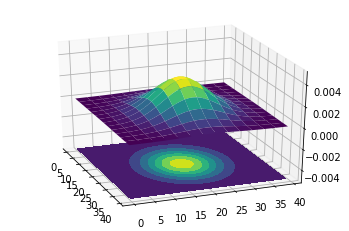

In [35]:
from itertools import product

# Compute the initial prior belief for the agent
w = h = 40 # Size of the world
mu = np.array([w/2., h/2.])# center point
Sigma = np.array([[40,0],[0,60]]) # Bimodal covariance with no dependence.

# Write your code here for computing the bivariate Gaussian function 
# Tip: You should normalize the belief to sum to 1. You can divide the belief by its sum to obtain it
# def bivariate_gaussian( ... ):
def bivariate_gaussian(x, mu, sigma):
    division = 1/math.sqrt((2*math.pi)**2*np.linalg.det(sigma))
    exp = math.exp(np.dot(-0.5*(x - mu).T, np.dot(np.linalg.inv(Sigma), (x-mu))))
    result = division * exp
    return result

bg = bivariate_gaussian(mu, mu, Sigma)
print(bg)

# Plot the initial belief
   
beliefs = np.zeros((40,40))
for i in range(width):
    for j in range(height):
        beliefs[i,j] = bivariate_gaussian([i,j], mu, Sigma)

x = np.arange(width)
y = np.arange(height)
X, Y = np.meshgrid(x, y)

beliefs = beliefs/np.sum(beliefs)
beliefs = beliefs.reshape((width, height))
print(beliefs.shape)    

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, beliefs, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
cset = ax.contourf(X, Y, beliefs, zdir='z', offset=-0.005, cmap=cm.viridis)
        
ax.set_zlim(-0.005,0.005)
ax.view_init(27, -21)
plt.show()

### 2. One agent search greedy 1 step discrete

We will program one agent search algorithm with 1-step ahead discrete (greedy). The idea is to select the next state that maximize the utility function: to maximize the probability of finding the target.

**Tip: This is the same as maximizing the (1- probability of not finding the target)**

The algorithm is as follows:
1. Compute the possible next states
2. Compute the utility for each new state
3. Select the maximum utility state $\arg \max$
4. Move the agent and perform an observation
5. Go to step 1

#### Utility function

To evaluate "how good" is a state we compute how much information gain we accumulate we exerting an action. That is, an action $u$ is better if the probability of finding the target $\tau$ is higher than others. As we have deterministic actions: an action always arrives to the same state, we can model the utility function given the state as:

$$ U(x) = \sum_\tau^k p(\overline{D}| x^k,\tau) b_\tau^{k-1}$$

This is the sum over all possible states of $\tau$ (marginalization) of the probability of non-detecting the target given the agent state and the target state.

Solving the problem is minimizing $U(x)$ or we can solve the maximization of $1-U(x)$.

In [74]:
##### Program the utility computation for all possible forward states (using the previous agent code and prior initialization)
# You need to program the utility function and the function that returns the next best state
tau = permutations(np.arange(width), 2)
#def utility( ... ):
def utility(mat, x, beliefs):
    fs, feasible = feasible_states(mat, x)
    sum = 0
#     indices = np.arange(0,40)
#     coords = product(indices, repeat=2)
    for state in feasible:
        pnd = sensor_pnd(Pdmax, dmax, sigma, x, state[0], state[1])
#         print('pnd: ', pnd)
        b = beliefs[int(state[0]), int(state[1])]
#         print('b: ', b)
#         print('pnd*b: ', pnd*b, '\n')
        sum = sum + pnd*b
    return sum

#def next_best_state( ... ):
def next_best_state(mat, x, beliefs):
    fs, feasible = feasible_states(mat, x)
    print(feasible)
    utilities = []
    for state in feasible:
        util = utility(mat, state, beliefs)
        utilities.append(util)
    print(utilities)
    print(np.argmax(utilities))
    max_index = np.argmax(utilities)
    return feasible[max_index]

x = [0,0]
xf = next_best_state(mat, x, beliefs)
print("best state", xf)

[[1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]]
[2.357245301110155e-06, 1.177093594894347e-06, 4.274925985761751e-06, 2.1350331922838907e-06]
2
best state [1. 1.]


### Algorithm

Write the full algorithm with a loop. Plot the agent trajectory as well as the belief map as in this figure:

<img src="img/solution.png" width="400" />

In [76]:
class Agent:

    # Constructor
    def __init__(self, i, state=np.array([0.,0.]), map_size = np.array([40, 40]), bk = np.ones(1600)*(1./1600) ):
        
        self.id = i  # Create an instance variable
        self.map_size = map_size       
        
        ## Environment. Tip it would be efficient to compute the grid into one vector as we did in the previous notebook        
        
        self.bk = bk

        ## Agent params
        self.x = state
        self.track = self.x.T # Stores all positions. Aux variable for visualization of the agent path
        self.height_plot = 0.1
        
        # add extra agents params
        
        ## Sensor params
        

    # get id
    def get_id(self):
        return self.id

    # compute discrete forward states 1 step ahead
    def forward(self):
        fs = []
        return fs
        
    # computes utility of forward states
    def nodetect_observation(self, x):
        pnd = []
        return pnd
        
    # computes utility of states
    def utility(self, fs):
        # compute cost funtion J of all potential forward states (brute force method)
        J = []
        return J
      
    # simulate agent next state
    def next(self, state):
        self.x = state
        self.track = np.vstack((self.track, self.x))

    # update belief with observation at state self.x
    def update_belief(self):
        pass
      
    def plot(self, ax):
        # Reshape belief for plotting
        bkx = self.bk.reshape((self.map_size[1], self.map_size[0]))
        ax.cla() # clear axis plot
        
        # plot contour of the P(\tau) -> self.bk
        

        # plot agent trajectory, self.track
        ax.plot(self.track[:, 0], self.track[:, 1], np.ones(self.track.shape[0]) * self.height_plot, 'r-', linewidth=2);
        ax.plot([self.track[-1, 0], self.track[-1, 0]], [self.track[-1, 1], self.track[-1, 1]], [self.height_plot, 0], 'ko-', linewidth=2);

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('P')


        # Adjust the limits, ticks and view angle
        ax.set_zlim(0, 0.12)
        ax.view_init(27, -21)


        plt.draw()
        plt.pause(0.1)  # animation
    

-------------------------------------------------

> One agent search 2D (greedy 1-step ahead)

[[14. 16.]
 [15. 16.]
 [16. 15.]
 [16. 14.]
 [14. 14.]
 [16. 16.]
 [15. 14.]
 [15. 15.]
 [14. 15.]]
[0.003977054503658631, 0.004552439877435661, 0.004721296056632391, 0.004312324117227966, 0.003373001704278193, 0.005084595027730492, 0.003860995022045291, 0.004227163861269848, 0.0036928902825942612]
5
normalization factor:  0.8730527184305494
iteration 0 [16. 16.]


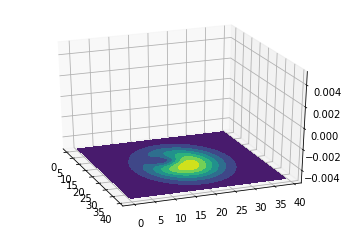

[[16. 17.]
 [16. 15.]
 [15. 17.]
 [17. 15.]
 [15. 16.]
 [16. 16.]
 [15. 15.]
 [17. 17.]
 [17. 16.]]
[0.0017239228087270204, 0.0014799354362384077, 0.001675465022114964, 0.0018036316544111214, 0.0014177415831443851, 0.0014380553786148798, 0.0014416435880501195, 0.002094681403229472, 0.0017802413866482775]
7
normalization factor:  0.9096456380393658
iteration 1 [17. 17.]


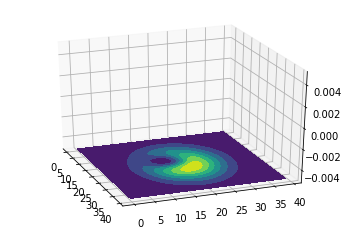

[[18. 18.]
 [18. 17.]
 [16. 18.]
 [17. 16.]
 [17. 18.]
 [17. 17.]
 [16. 17.]
 [16. 16.]
 [18. 16.]]
[0.0012410083323326517, 0.0008998823310377893, 0.0008147545172356157, 0.0005397019450307591, 0.000879031409904049, 0.0005718101964756339, 0.0005197793024376699, 0.00047547274752906323, 0.0008637433779587774]
0
normalization factor:  0.9208586107177187
iteration 2 [18. 18.]


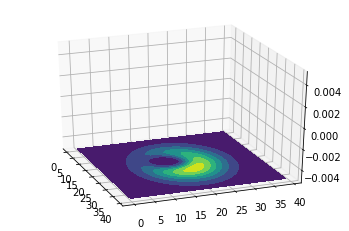

[[19. 17.]
 [18. 17.]
 [18. 18.]
 [17. 18.]
 [17. 17.]
 [19. 19.]
 [18. 19.]
 [19. 18.]
 [17. 19.]]
[0.0005564887722809312, 0.00026570263748271325, 0.0003358396470324704, 0.00025845134710561295, 0.00017829841172115057, 0.0009799415423435661, 0.0006275597065433402, 0.0006357343694235245, 0.0005356936696776645]
5
normalization factor:  0.9257975547470016
iteration 3 [19. 19.]


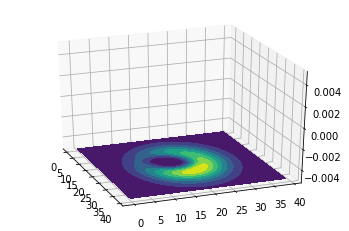

[[19. 18.]
 [19. 19.]
 [19. 20.]
 [18. 18.]
 [20. 18.]
 [20. 19.]
 [20. 20.]
 [18. 19.]
 [18. 20.]]
[0.00018435172053056232, 0.000264342577103645, 0.0005491273107862925, 9.947824842999916e-05, 0.00045255454117823436, 0.0005502994229946546, 0.0008980677262313063, 0.00018148189207311605, 0.0004451985667041441]
6
normalization factor:  0.928780502283925
iteration 4 [20. 20.]


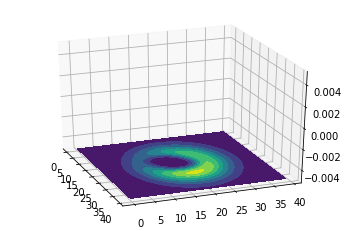

[[20. 20.]
 [21. 20.]
 [21. 21.]
 [19. 21.]
 [19. 20.]
 [21. 19.]
 [20. 19.]
 [20. 21.]
 [19. 19.]]
[0.0002417100199436476, 0.0005214323591675324, 0.0008689435760092574, 0.0004190374504017452, 0.00015738952086076058, 0.0004167790065875924, 0.00015791715653000926, 0.0005259513754922603, 7.60190425573631e-05]
2
normalization factor:  0.9319515506724383
iteration 5 [21. 21.]


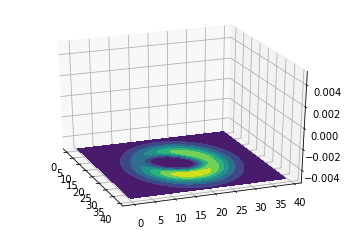

[[22. 20.]
 [21. 22.]
 [21. 20.]
 [22. 21.]
 [22. 22.]
 [21. 21.]
 [20. 20.]
 [20. 21.]
 [20. 22.]]
[0.0004008907122896653, 0.0005138581788234381, 0.00014866654653090646, 0.000504015761593998, 0.0008404195032958835, 0.00023312030666058448, 6.845980415585322e-05, 0.00015000216098615674, 0.0004118953334691569]
4
normalization factor:  0.93633224238244
iteration 6 [22. 22.]


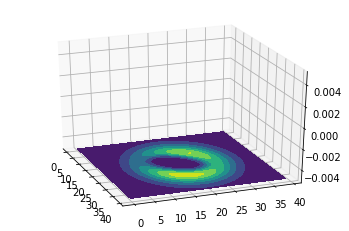

[[21. 23.]
 [21. 21.]
 [23. 22.]
 [22. 23.]
 [23. 21.]
 [21. 22.]
 [22. 21.]
 [22. 22.]
 [23. 23.]]
[0.00040260880445154687, 6.550833148888221e-05, 0.000478111037398801, 0.000492696886157357, 0.00038346997350680343, 0.00014601944722643468, 0.00014295812132246588, 0.00022436759837980968, 0.0007898990326958355]
8
normalization factor:  0.9422273691539749
iteration 7 [23. 23.]


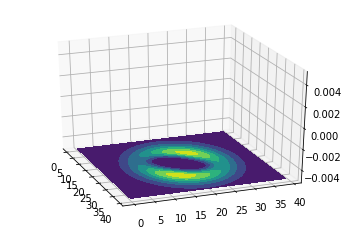

[[23. 24.]
 [23. 22.]
 [22. 22.]
 [24. 24.]
 [23. 23.]
 [24. 22.]
 [22. 24.]
 [24. 23.]
 [22. 23.]]
[0.0004549695456852785, 0.00013488086058410263, 6.27427340833733e-05, 0.0007121116177210466, 0.0002094844697716779, 0.00035544839411396126, 0.0003813560504104403, 0.0004367808484272113, 0.00013946870404143665]
3
normalization factor:  0.9494416932727797
iteration 8 [24. 24.]


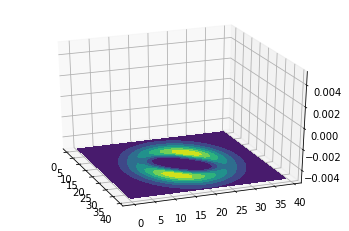

[[23. 25.]
 [25. 25.]
 [25. 23.]
 [25. 24.]
 [24. 25.]
 [23. 24.]
 [23. 23.]
 [24. 24.]
 [24. 23.]]
[0.0003459163216289318, 0.0006124091007182826, 0.0003154891013766415, 0.0003811644234498435, 0.00040134842755248164, 0.0001282034120987215, 5.8343895832249886e-05, 0.00018734266344569466, 0.00012246862756236515]
1
normalization factor:  0.9574624542227727
iteration 9 [25. 25.]


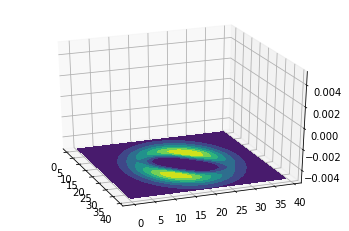

[[24. 26.]
 [24. 24.]
 [26. 24.]
 [26. 25.]
 [25. 25.]
 [25. 26.]
 [26. 26.]
 [24. 25.]
 [25. 24.]]
[0.0002990787679939865, 5.197092276139136e-05, 0.00026688749190925594, 0.0003167802446900414, 0.00015969659197243588, 0.00033719627263529336, 0.000501381047284041, 0.00011251984888171675, 0.00010616362112971267]
6
normalization factor:  0.9656416151820787
iteration 10 [26. 26.]


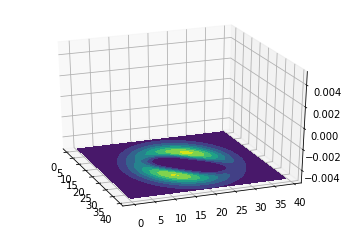

[[27. 26.]
 [26. 26.]
 [26. 25.]
 [27. 27.]
 [25. 26.]
 [25. 27.]
 [25. 25.]
 [27. 25.]
 [26. 27.]]
[0.00025054772823393393, 0.00012958366789203016, 8.764304469482891e-05, 0.0003906155710394738, 9.405491179433175e-05, 0.00024615962018008407, 4.41359951296695e-05, 0.00021490626988937724, 0.00026962231502370137]
3
normalization factor:  0.9733634722436417
iteration 11 [27. 27.]


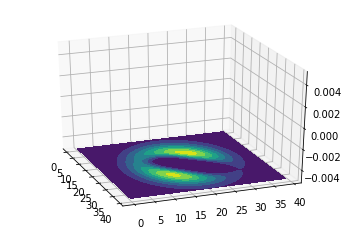

[[27. 27.]
 [28. 27.]
 [26. 28.]
 [26. 26.]
 [26. 27.]
 [28. 26.]
 [27. 26.]
 [28. 28.]
 [27. 28.]]
[0.00010011533925618324, 0.00018866163186141908, 0.00019291538803458986, 3.5702702276791385e-05, 7.486843562968288e-05, 0.00016475930407908635, 6.889580106856613e-05, 0.00028973036966014335, 0.0002052647439362663]
7
normalization factor:  0.9801668874129138
iteration 12 [28. 28.]


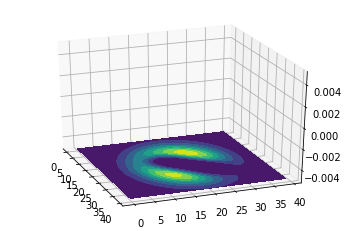

[[28. 28.]
 [28. 27.]
 [28. 29.]
 [29. 29.]
 [29. 28.]
 [27. 27.]
 [29. 27.]
 [27. 28.]
 [27. 29.]]
[7.371460041696974e-05, 5.1614101871844494e-05, 0.00014892974851124494, 0.000204800882050624, 0.0001353821159174837, 2.7526886488133423e-05, 0.00012037547763393734, 5.679974653657791e-05, 0.00014409243893585084]
3
normalization factor:  0.9858005175077258
iteration 13 [29. 29.]


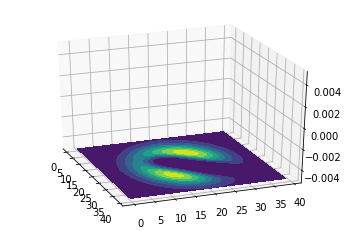

[[30. 28.]
 [28. 28.]
 [29. 30.]
 [28. 29.]
 [29. 28.]
 [30. 30.]
 [29. 29.]
 [30. 29.]
 [28. 30.]]
[8.391626928790584e-05, 2.025174735246024e-05, 0.00010310797501903796, 4.111942463901084e-05, 3.6895091295135106e-05, 0.00013813372713396215, 5.1789473834359006e-05, 9.269570333844351e-05, 0.00010270001869092122]
5
normalization factor:  0.9902132757315281
iteration 14 [30. 30.]


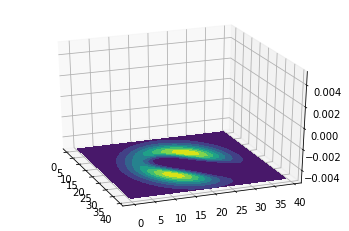

[[30. 31.]
 [31. 31.]
 [31. 30.]
 [29. 29.]
 [29. 31.]
 [30. 30.]
 [29. 30.]
 [31. 29.]
 [30. 29.]]
[6.820196391469705e-05, 8.901198297390161e-05, 6.0635861938829086e-05, 1.4235119092492737e-05, 6.993639512883822e-05, 3.4762805636179456e-05, 2.844119730413298e-05, 5.588883209731593e-05, 2.519662682356608e-05]
1
normalization factor:  0.9935026606294791
iteration 15 [31. 31.]


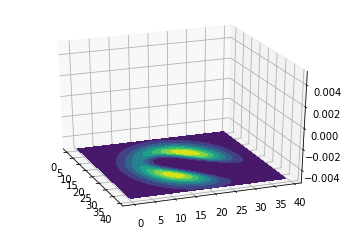

[[30. 31.]
 [31. 32.]
 [30. 30.]
 [31. 31.]
 [30. 32.]
 [31. 30.]
 [32. 31.]
 [32. 32.]
 [32. 30.]]
[1.8816900287589e-05, 4.3151478422651844e-05, 9.570886710578769e-06, 2.231898475072488e-05, 4.5555246876116575e-05, 1.6458522463841658e-05, 3.793783178186277e-05, 5.4862919128275786e-05, 3.560213589497909e-05]
7
normalization factor:  0.9958492803715507
iteration 16 [32. 32.]


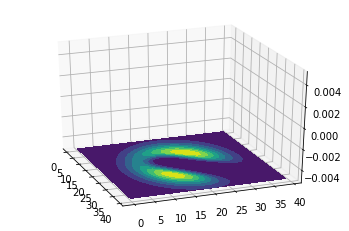

[[31. 32.]
 [32. 31.]
 [33. 32.]
 [31. 31.]
 [31. 33.]
 [32. 33.]
 [33. 31.]
 [33. 33.]
 [32. 32.]]
[1.1919643424318456e-05, 1.0292751288425349e-05, 2.272511528969295e-05, 6.161012062203708e-06, 2.841131456858216e-05, 2.6139978782516637e-05, 2.1712859464165552e-05, 3.23748765125549e-05, 1.3719478617100512e-05]
7
normalization factor:  0.9974589111512537
iteration 17 [33. 33.]


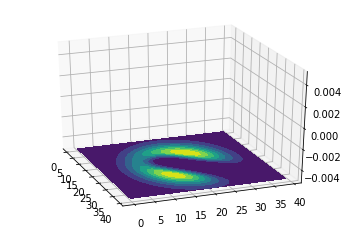

[[34. 33.]
 [34. 32.]
 [34. 34.]
 [32. 34.]
 [33. 34.]
 [33. 33.]
 [32. 32.]
 [32. 33.]
 [33. 32.]]
[1.3042335990049938e-05, 1.2687416110501067e-05, 1.830461420170765e-05, 1.697792841488392e-05, 1.5172231949007247e-05, 8.080328086376843e-06, 3.800008776404506e-06, 7.2346315002974895e-06, 6.167218519045026e-06]
2
normalization factor:  0.9985224621760731
iteration 18 [34. 34.]


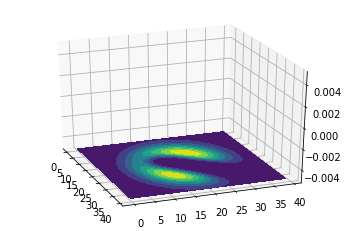

[[34. 34.]
 [35. 33.]
 [35. 35.]
 [33. 34.]
 [34. 35.]
 [33. 35.]
 [34. 33.]
 [35. 34.]
 [33. 33.]]
[4.562349736525738e-06, 7.106980997925199e-06, 9.921471451087225e-06, 4.209648448842092e-06, 8.442433315162805e-06, 9.726497548381359e-06, 3.5424588125711383e-06, 7.175642365635797e-06, 2.2469270283945054e-06]
2
normalization factor:  0.9991959342771433
iteration 19 [35. 35.]


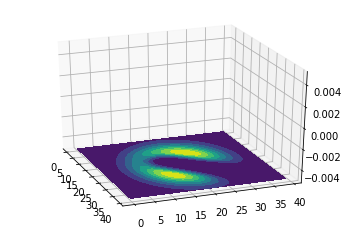

[[36. 34.]
 [36. 35.]
 [34. 34.]
 [34. 35.]
 [35. 34.]
 [34. 36.]
 [35. 36.]
 [35. 35.]
 [36. 36.]]
[3.8179034559885356e-06, 3.7861175059059817e-06, 1.274194372648867e-06, 2.3492061011267105e-06, 1.951415154635513e-06, 5.344117118053962e-06, 4.505368099756688e-06, 2.4705159617495497e-06, 5.157340306294357e-06]
5
normalization factor:  0.9991387303666935
iteration 20 [34. 36.]


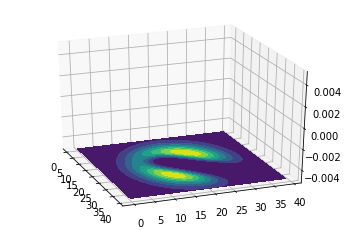

[[34. 35.]
 [33. 37.]
 [35. 37.]
 [35. 35.]
 [33. 36.]
 [34. 36.]
 [34. 37.]
 [35. 36.]
 [33. 35.]]
[5.91204311801616e-07, 6.1464621923956e-06, 2.7315042411788002e-06, 7.493800977609177e-07, 2.6708602420150574e-06, 1.339622801424175e-06, 3.3582131294954833e-06, 1.2664876459957618e-06, 1.1337287638114956e-06]
1
normalization factor:  0.9989389658089769
iteration 21 [33. 37.]


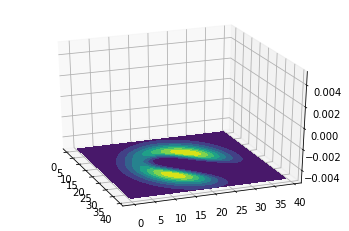

[[34. 37.]
 [34. 38.]
 [33. 37.]
 [33. 38.]
 [33. 36.]
 [32. 37.]
 [34. 36.]
 [32. 36.]
 [32. 38.]]
[8.939730174892907e-07, 2.3352911822290135e-06, 1.5448502392574644e-06, 3.7186274199714366e-06, 6.647942584495237e-07, 4.4079894788870545e-06, 3.5411489394974363e-07, 2.3245099769726904e-06, 8.394948878706216e-06]
8
normalization factor:  0.9987211864220482
iteration 22 [32. 38.]


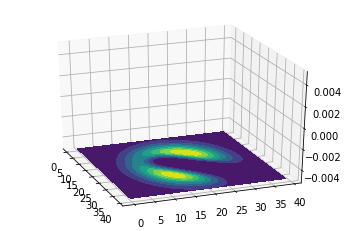

[[31. 37.]
 [33. 38.]
 [32. 37.]
 [33. 39.]
 [31. 39.]
 [32. 38.]
 [31. 38.]
 [32. 39.]
 [33. 37.]]
[4.706125405679638e-06, 9.589208202966127e-07, 1.1302929093321572e-06, 8.021886451654171e-07, 5.108334657608111e-06, 2.1095903202963655e-06, 6.811788496170849e-06, 1.6821337493216566e-06, 3.877739613633466e-07]
6
normalization factor:  0.998269388827497
iteration 23 [31. 38.]


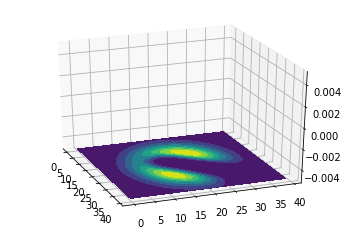

[[30. 38.]
 [31. 39.]
 [32. 38.]
 [31. 38.]
 [32. 37.]
 [30. 39.]
 [31. 37.]
 [30. 37.]
 [32. 39.]]
[7.221077727241595e-06, 1.2640027011905727e-06, 5.242863873010713e-07, 1.7194524665043475e-06, 2.868856795201312e-07, 4.991328299241477e-06, 1.2747554249641072e-06, 6.3917491267145196e-06, 4.1409542759904046e-07]
0
normalization factor:  0.9976743044077024
iteration 24 [30. 38.]


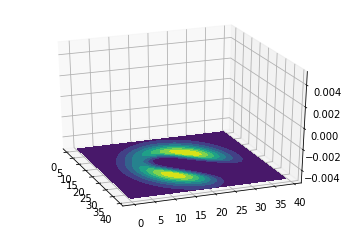

[[30. 37.]
 [29. 38.]
 [31. 38.]
 [29. 39.]
 [31. 37.]
 [31. 39.]
 [30. 39.]
 [30. 38.]
 [29. 37.]]
[1.80970144495777e-06, 8.792176464729337e-06, 4.138974052020564e-07, 5.641916044153054e-06, 3.359782613978753e-07, 2.9980992293819324e-07, 1.233362645969169e-06, 1.8290231998647448e-06, 9.509239908860252e-06]
8
normalization factor:  0.9963219125852438
iteration 25 [29. 37.]


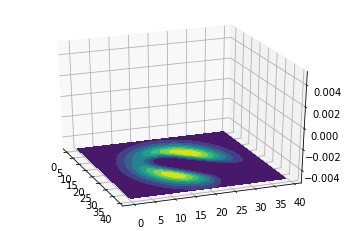

[[29. 38.]
 [29. 37.]
 [30. 38.]
 [28. 36.]
 [30. 37.]
 [29. 36.]
 [28. 38.]
 [28. 37.]
 [30. 36.]]
[2.512749162128903e-06, 2.415891692198991e-06, 5.051940988220556e-07, 1.7084043532459648e-05, 4.235247576205791e-07, 3.461116248368346e-06, 1.2081253937884883e-05, 1.2862018099697034e-05, 6.536331113920368e-07]
3
normalization factor:  0.9945135314154656
iteration 26 [28. 36.]


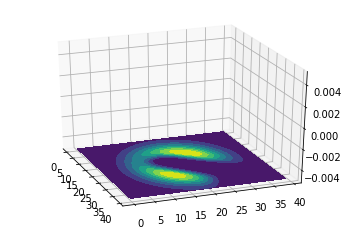

[[29. 36.]
 [29. 37.]
 [27. 36.]
 [28. 35.]
 [28. 37.]
 [27. 37.]
 [28. 36.]
 [27. 35.]
 [29. 35.]]
[8.120347918645449e-07, 6.191514361057129e-07, 2.178648922304998e-05, 6.953042515181161e-06, 3.558223473139028e-06, 1.8132355650276646e-05, 4.343705705757105e-06, 3.084580548033714e-05, 1.485387531102578e-06]
7
normalization factor:  0.9922532660040252
iteration 27 [27. 35.]


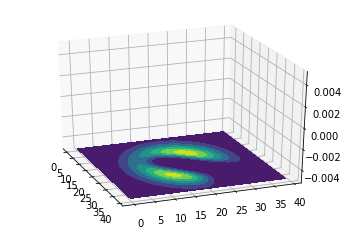

[[26. 34.]
 [28. 35.]
 [26. 35.]
 [27. 34.]
 [26. 36.]
 [28. 34.]
 [27. 35.]
 [28. 36.]
 [27. 36.]]
[5.126137603004363e-05, 1.6442717829618286e-06, 3.6142746652655984e-05, 1.2671297271228566e-05, 2.906535291221698e-05, 3.0381367862828696e-06, 7.845803775510483e-06, 1.0877766973691288e-06, 5.949633149859418e-06]
0
normalization factor:  0.9895882703746576
iteration 28 [26. 34.]


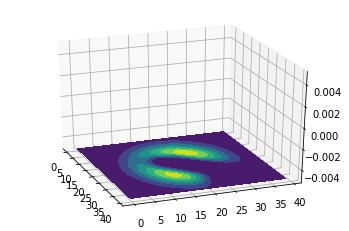

[[27. 35.]
 [26. 33.]
 [27. 34.]
 [25. 34.]
 [26. 34.]
 [25. 33.]
 [26. 35.]
 [27. 33.]
 [25. 35.]]
[1.9658670588320437e-06, 2.058822468343066e-05, 3.0221013334360677e-06, 5.5912768342942766e-05, 1.3050102526468425e-05, 7.78023446749237e-05, 9.85430982132203e-06, 5.397201909802349e-06, 4.523385613063256e-05]
5
normalization factor:  0.9866051680650024
iteration 29 [25. 33.]


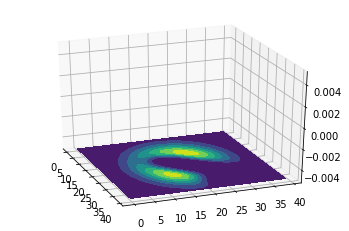

[[24. 33.]
 [25. 34.]
 [24. 32.]
 [25. 33.]
 [25. 32.]
 [26. 33.]
 [24. 34.]
 [26. 34.]
 [26. 32.]]
[8.056653457352077e-05, 1.529911087853305e-05, 0.00010962359746878716, 1.983928847892071e-05, 3.0422528475596622e-05, 4.949670740463319e-06, 6.647195836757822e-05, 3.2993405101907896e-06, 8.497634022186013e-06]
2
normalization factor:  0.9834300918651782
iteration 30 [24. 32.]


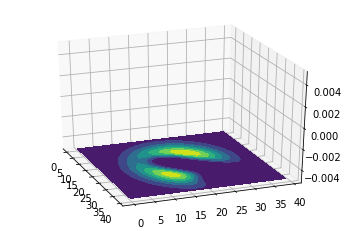

[[25. 32.]
 [25. 31.]
 [25. 33.]
 [24. 32.]
 [24. 33.]
 [23. 31.]
 [24. 31.]
 [23. 33.]
 [23. 32.]]
[7.365664969808675e-06, 1.2238197275777171e-05, 5.069647241366495e-06, 2.8016581678485192e-05, 2.2164298948309202e-05, 0.0001459175909972511, 4.191073295597475e-05, 9.229159445966392e-05, 0.00010945605520123635]
5
normalization factor:  0.9802285806702249
iteration 31 [23. 31.]


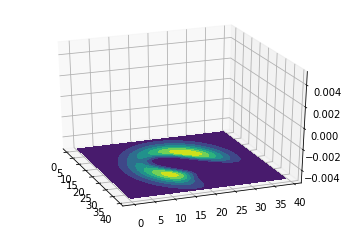

[[22. 31.]
 [24. 32.]
 [23. 32.]
 [22. 32.]
 [22. 30.]
 [24. 31.]
 [23. 31.]
 [23. 30.]
 [24. 30.]]
[0.00014174199155546165, 7.229802423468645e-06, 3.028350854264092e-05, 0.00012199680464885705, 0.00018553111808672766, 1.0208919727283216e-05, 3.738738850995441e-05, 5.4785829099349917e-05, 1.6541517586560332e-05]
4
normalization factor:  0.977196957194059
iteration 32 [22. 30.]


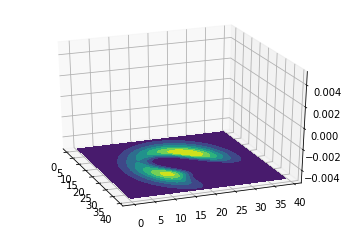

[[23. 31.]
 [23. 29.]
 [21. 31.]
 [22. 31.]
 [23. 30.]
 [22. 29.]
 [21. 29.]
 [22. 30.]
 [21. 30.]]
[9.729857233334579e-06, 2.1300849442628978e-05, 0.00015445576400341697, 3.9428008677654674e-05, 1.3415867904225067e-05, 6.857319698478461e-05, 0.00022648242744827956, 4.765652869745424e-05, 0.0001760129648796437]
6
normalization factor:  0.9745403105875168
iteration 33 [21. 29.]


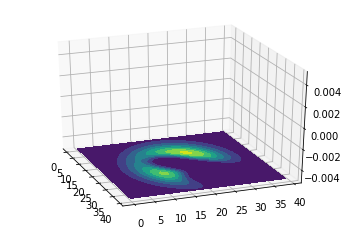

[[21. 28.]
 [21. 29.]
 [22. 29.]
 [21. 30.]
 [20. 28.]
 [20. 30.]
 [22. 28.]
 [20. 29.]
 [22. 30.]]
[8.247105822775189e-05, 5.830231265591103e-05, 1.6870181091655824e-05, 4.920096929478506e-05, 0.0002658999131756037, 0.00018783057767675224, 2.630678875502526e-05, 0.00021007728726412736, 1.249362635625429e-05]
4
normalization factor:  0.9724382981595416
iteration 34 [20. 28.]


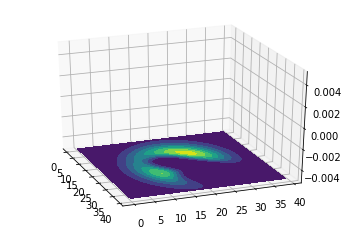

[[20. 28.]
 [21. 28.]
 [21. 27.]
 [19. 28.]
 [19. 27.]
 [21. 29.]
 [20. 29.]
 [20. 27.]
 [19. 29.]]
[6.85614563581479e-05, 2.0370768422679995e-05, 3.123346183691755e-05, 0.00024113279668881032, 0.0003004685031297859, 1.5383496590296355e-05, 5.897360670202757e-05, 9.542330260306679e-05, 0.00021956881092123542]
4
normalization factor:  0.971005618577348
iteration 35 [19. 27.]


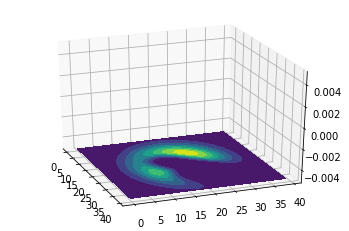

[[18. 28.]
 [19. 26.]
 [18. 26.]
 [18. 27.]
 [20. 27.]
 [19. 28.]
 [19. 27.]
 [20. 28.]
 [20. 26.]]
[0.0002467274389948555, 0.00010638863089268046, 0.00032732642734118714, 0.000266295017661681, 2.3648796433960626e-05, 6.793000023425373e-05, 7.755056945633436e-05, 1.8192961497408785e-05, 3.5705348938926166e-05]
2
normalization factor:  0.9702590162397807
iteration 36 [18. 26.]


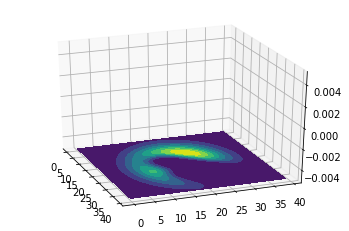

[[19. 26.]
 [18. 25.]
 [19. 25.]
 [17. 25.]
 [18. 27.]
 [19. 27.]
 [17. 26.]
 [18. 26.]
 [17. 27.]]
[2.6436608648667232e-05, 0.00011478970179130443, 3.944987781699763e-05, 0.0003452603835585828, 7.521887144426481e-05, 2.0677483864448917e-05, 0.0002833931978806877, 8.450977234698862e-05, 0.00026656901781400854]
3
normalization factor:  0.9701052307003383
iteration 37 [17. 25.]


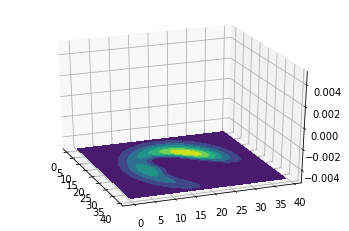

[[16. 25.]
 [16. 24.]
 [17. 25.]
 [16. 26.]
 [17. 24.]
 [18. 24.]
 [18. 25.]
 [17. 26.]
 [18. 26.]]
[0.00029179439833668406, 0.0003557040127156898, 8.91224721432328e-05, 0.00027728816443582725, 0.00012103698694615657, 4.252695175872859e-05, 2.8583728836768214e-05, 8.018286987306769e-05, 2.2619562767261985e-05]
1
normalization factor:  0.9703620370369274
iteration 38 [16. 24.]


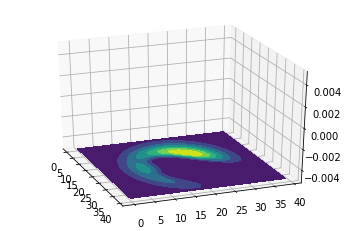

[[15. 25.]
 [17. 23.]
 [16. 24.]
 [16. 23.]
 [17. 25.]
 [15. 24.]
 [17. 24.]
 [15. 23.]
 [16. 25.]]
[0.0002785729224542399, 4.5577944500499554e-05, 9.177347704658393e-05, 0.00012686288836764132, 2.391476871427858e-05, 0.000292754257121445, 3.0192394185340813e-05, 0.00036270357907776016, 8.259390981473264e-05]
7
normalization factor:  0.9708182385112617
iteration 39 [15. 23.]


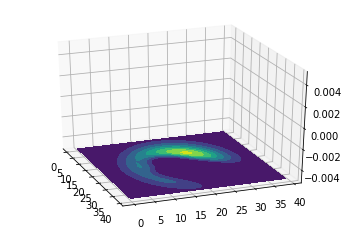

[[15. 24.]
 [15. 22.]
 [16. 24.]
 [16. 22.]
 [14. 24.]
 [15. 23.]
 [14. 23.]
 [14. 22.]
 [16. 23.]]
[8.275645400060105e-05, 0.00013517376539918518, 2.4643547199562796e-05, 5.002064156555245e-05, 0.0002715888534675531, 9.352623666389491e-05, 0.00028876272163779837, 0.0003712136892847621, 3.170692697511053e-05]
7
normalization factor:  0.9713280445123635
iteration 40 [14. 22.]


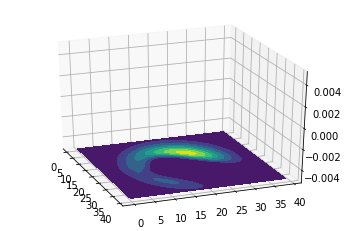

[[14. 23.]
 [13. 23.]
 [13. 22.]
 [14. 21.]
 [14. 22.]
 [15. 21.]
 [15. 23.]
 [15. 22.]
 [13. 21.]]
[8.133566912263663e-05, 0.0002581807772198154, 0.00028186031147581843, 0.00014919625213467434, 9.566296605860378e-05, 5.8184882665616904e-05, 2.5072963089002398e-05, 3.388760825868403e-05, 0.00038374280484650494]
8
normalization factor:  0.9719113217329414
iteration 41 [13. 21.]


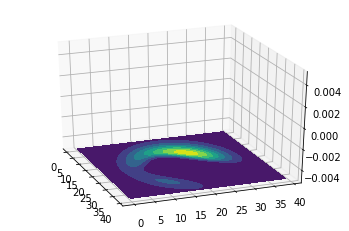

[[13. 22.]
 [12. 22.]
 [13. 20.]
 [12. 20.]
 [14. 20.]
 [13. 21.]
 [12. 21.]
 [14. 22.]
 [14. 21.]]
[7.890585749201025e-05, 0.0002396776472015315, 0.00017044610181095101, 0.0003963339567460279, 7.322518595524073e-05, 9.88059886840505e-05, 0.00027174438760779393, 2.5547187240090963e-05, 3.762114781833138e-05]
3
normalization factor:  0.9727919078767029
iteration 42 [12. 20.]


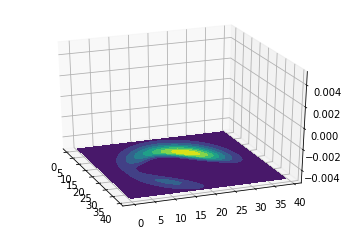

[[12. 20.]
 [11. 20.]
 [11. 19.]
 [12. 19.]
 [12. 21.]
 [11. 21.]
 [13. 20.]
 [13. 19.]
 [13. 21.]]
[0.00010189145075654567, 0.00025523920466458073, 0.00039714124735840155, 0.0001952200594721761, 7.544700676097958e-05, 0.0002162358456716457, 4.344790388625e-05, 9.77049842440545e-05, 2.627055245329047e-05]
2
normalization factor:  0.9743003421854994
iteration 43 [11. 19.]


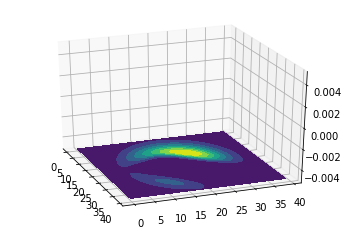

[[11. 20.]
 [11. 19.]
 [12. 18.]
 [10. 20.]
 [11. 18.]
 [12. 19.]
 [10. 19.]
 [10. 18.]
 [12. 20.]]
[7.021428683551828e-05, 0.00010185067462029593, 0.00012914519350749884, 0.00018751679619127392, 0.00021235366648113998, 5.0643847459489915e-05, 0.00022855607667213943, 0.00037253505406014293, 2.704259222562217e-05]
7
normalization factor:  0.9766625254387
iteration 44 [10. 18.]


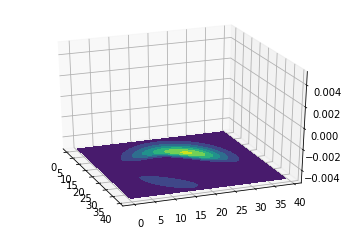

[[10. 17.]
 [ 9. 19.]
 [11. 18.]
 [ 9. 18.]
 [11. 17.]
 [ 9. 17.]
 [11. 19.]
 [10. 18.]
 [10. 19.]]
[0.0002086673679147695, 0.0001543186209480293, 5.634046061423514e-05, 0.00019133963491461725, 0.0001551509175383164, 0.00031910788594216724, 2.7125656927126113e-05, 9.522960669168894e-05, 6.233324346540051e-05]
5
normalization factor:  0.979828232551444
iteration 45 [ 9. 17.]


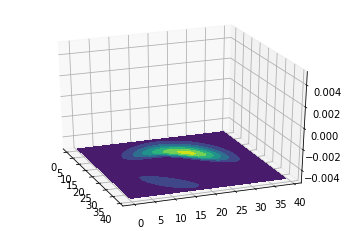

[[ 8. 17.]
 [ 9. 18.]
 [ 8. 18.]
 [10. 17.]
 [10. 16.]
 [ 8. 16.]
 [ 9. 17.]
 [10. 18.]
 [ 9. 16.]]
[0.00014840880824807604, 5.182175468887456e-05, 0.00011947291472220817, 5.657643905147465e-05, 0.00015968060100707667, 0.0002483541923473117, 8.125800989736473e-05, 2.5569866826625895e-05, 0.000181089841289764]
5
normalization factor:  0.9834790716531937
iteration 46 [ 8. 16.]


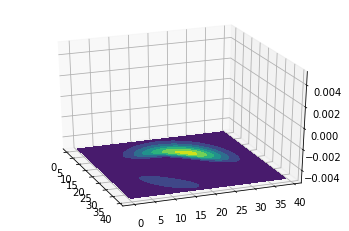

[[ 7. 17.]
 [ 9. 17.]
 [ 8. 15.]
 [ 7. 16.]
 [ 8. 16.]
 [ 9. 16.]
 [ 8. 17.]
 [ 9. 15.]
 [ 7. 15.]]
[8.685297068437321e-05, 2.2029667752779634e-05, 0.00013980376753977553, 0.00010690726845957034, 6.297787235835288e-05, 4.9900439864994756e-05, 3.9995157378722744e-05, 0.00013961847394446139, 0.0001774344568525219]
8
normalization factor:  0.9871860976690847
iteration 47 [ 7. 15.]


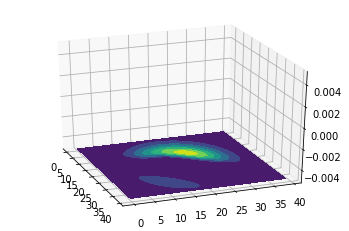

[[ 8. 15.]
 [ 6. 15.]
 [ 8. 14.]
 [ 7. 14.]
 [ 7. 15.]
 [ 8. 16.]
 [ 7. 16.]
 [ 6. 16.]
 [ 6. 14.]]
[3.890827794157619e-05, 7.214902297615007e-05, 0.00010655978764103203, 9.817503698660997e-05, 4.480869963794871e-05, 1.7217257417623124e-05, 2.8716297254501827e-05, 5.95008508732397e-05, 0.0001181603901513832]
8
normalization factor:  0.9905774874281709
iteration 48 [ 6. 14.]


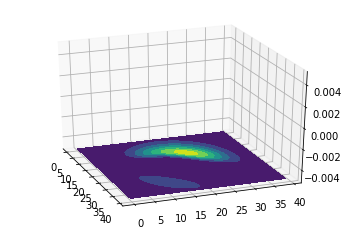

[[ 7. 13.]
 [ 5. 15.]
 [ 5. 13.]
 [ 6. 15.]
 [ 7. 15.]
 [ 7. 14.]
 [ 5. 14.]
 [ 6. 14.]
 [ 6. 13.]]
[7.35612542808156e-05, 3.863028265996828e-05, 7.429036235796415e-05, 1.9340449097495945e-05, 1.2326993705645532e-05, 2.747107430107199e-05, 4.603910812145351e-05, 2.9728075572594102e-05, 6.412787662261779e-05]
2
normalization factor:  0.9934238665140449
iteration 49 [ 5. 13.]


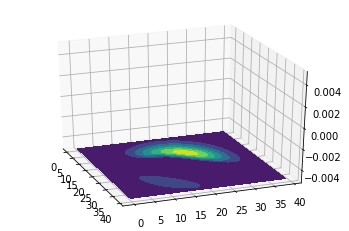

[[ 4. 13.]
 [ 6. 12.]
 [ 6. 13.]
 [ 5. 14.]
 [ 5. 13.]
 [ 4. 14.]
 [ 5. 12.]
 [ 6. 14.]
 [ 4. 12.]]
[2.796419964959956e-05, 4.724165578016297e-05, 1.7998681284380235e-05, 1.2327601100148734e-05, 1.8631618654022774e-05, 2.3886808983640183e-05, 3.957389205184341e-05, 8.216417655464577e-06, 4.4453768658261115e-05]
1
normalization factor:  0.9916360374253803
iteration 50 [ 6. 12.]


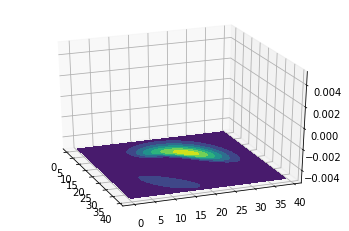

[[ 5. 12.]
 [ 5. 13.]
 [ 6. 12.]
 [ 6. 11.]
 [ 6. 13.]
 [ 7. 12.]
 [ 7. 13.]
 [ 7. 11.]
 [ 5. 11.]]
[1.1203991399772926e-05, 5.589732843156246e-06, 1.1957740212853938e-05, 3.44383214075302e-05, 4.491937304580463e-06, 2.3496445678634538e-05, 8.572967012060703e-06, 6.213452260319107e-05, 2.789269833791777e-05]
7
normalization factor:  0.9885938174953555
iteration 51 [ 7. 11.]


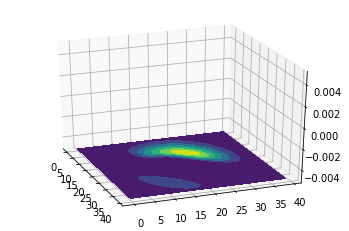

[[ 8. 11.]
 [ 7. 10.]
 [ 8. 12.]
 [ 6. 12.]
 [ 8. 10.]
 [ 6. 11.]
 [ 7. 12.]
 [ 6. 10.]
 [ 7. 11.]]
[4.3664847313785244e-05, 4.3810243197178666e-05, 1.9657352652626446e-05, 3.153912043879694e-06, 9.635432951438922e-05, 9.286123226814102e-06, 5.82489278398294e-06, 2.7771087153598847e-05, 1.5813193283071764e-05]
4
normalization factor:  0.9849803019456216
iteration 52 [ 8. 10.]


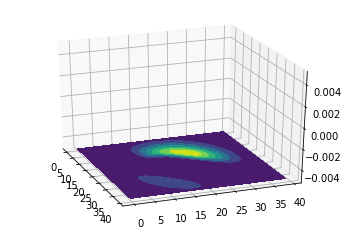

[[ 9.  9.]
 [ 7.  9.]
 [ 8. 10.]
 [ 8. 11.]
 [ 8.  9.]
 [ 7. 10.]
 [ 9. 10.]
 [ 9. 11.]
 [ 7. 11.]]
[0.00013966888303127786, 3.3650231754785926e-05, 2.4592945196658566e-05, 1.1143767050509638e-05, 5.938834310813337e-05, 1.1499097211032157e-05, 7.619091952748391e-05, 4.422919940616885e-05, 3.975635244094896e-06]
0
normalization factor:  0.9814149294678852
iteration 53 [9. 9.]


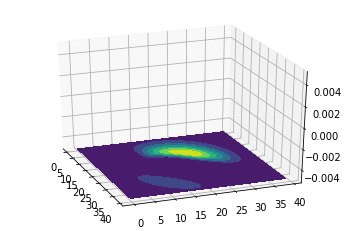

[[10. 10.]
 [ 9.  9.]
 [ 9.  8.]
 [ 9. 10.]
 [10.  9.]
 [ 8.  9.]
 [10.  8.]
 [ 8.  8.]
 [ 8. 10.]]
[8.097221548618171e-05, 3.572599070796925e-05, 7.553639287036507e-05, 2.0112875098996e-05, 0.00011262825640732073, 1.5433987182477246e-05, 0.0001784749090548839, 4.1564065260223e-05, 6.202136853198993e-06]
6
normalization factor:  0.978426628644292
iteration 54 [10.  8.]


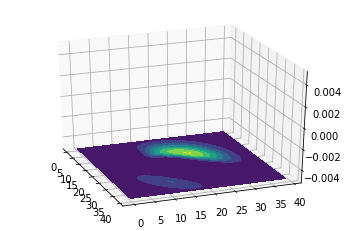

[[ 9.  8.]
 [10.  9.]
 [10.  7.]
 [ 9.  7.]
 [11.  9.]
 [11.  8.]
 [10.  8.]
 [ 9.  9.]
 [11.  7.]]
[1.9610155432519117e-05, 3.058810096971176e-05, 8.753256721020609e-05, 4.868604912016205e-05, 0.00011884163911281546, 0.00014138932140864586, 4.573673621484816e-05, 9.183431473027668e-06, 0.00020279528161467952]
8
normalization factor:  0.9764042465086626
iteration 55 [11.  7.]


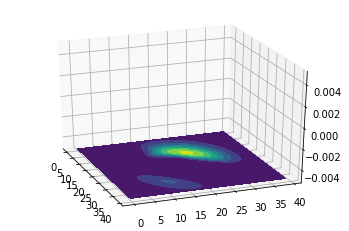

[[12.  6.]
 [11.  6.]
 [10.  6.]
 [11.  8.]
 [10.  7.]
 [12.  7.]
 [10.  8.]
 [12.  8.]
 [11.  7.]]
[0.0002106053077559721, 9.329138010461763e-05, 5.32382340123159e-05, 3.9164721314704506e-05, 2.2783908412096185e-05, 0.00015633106362011694, 1.1989433342840701e-05, 0.000145759230317496, 5.203295499492981e-05]
0
normalization factor:  0.9756005473264042
iteration 56 [12.  6.]


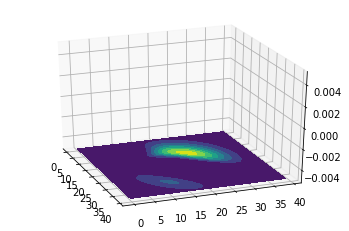

[[12.  5.]
 [13.  7.]
 [12.  6.]
 [11.  6.]
 [13.  5.]
 [13.  6.]
 [12.  7.]
 [11.  5.]
 [11.  7.]]
[9.305263194797641e-05, 0.00015726949538846365, 5.40487583762628e-05, 2.436096598995705e-05, 0.00020465725793094233, 0.00015796258365459003, 4.381784796202999e-05, 5.466957641275985e-05, 1.3840802547762924e-05]
4
normalization factor:  0.9761369008894537
iteration 57 [13.  5.]


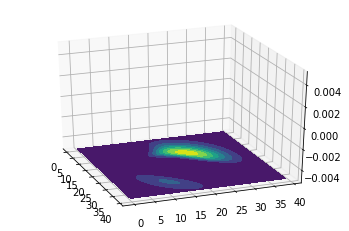

[[14.  6.]
 [13.  6.]
 [12.  4.]
 [14.  5.]
 [14.  4.]
 [12.  6.]
 [13.  4.]
 [12.  5.]
 [13.  5.]]
[0.0001552421355229958, 4.4542345913609796e-05, 5.319723635021931e-05, 0.0001494602580396559, 0.00018860295877050985, 1.4509028607608659e-05, 8.795884183296316e-05, 2.4355888978383314e-05, 5.2467864446093264e-05]
4
normalization factor:  0.9779723446237878
iteration 58 [14.  4.]


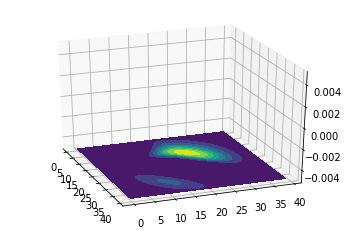

[[13.  5.]
 [14.  5.]
 [15.  3.]
 [14.  4.]
 [13.  4.]
 [13.  3.]
 [15.  5.]
 [15.  4.]
 [14.  3.]]
[1.4155976367023775e-05, 4.2239575903214826e-05, 0.0001657546516010283, 4.82397813584664e-05, 2.3048071092772687e-05, 4.93296978369509e-05, 0.00014344113986305862, 0.0001340536098213702, 7.926874632467197e-05]
2
normalization factor:  0.9808589570745988
iteration 59 [15.  3.]


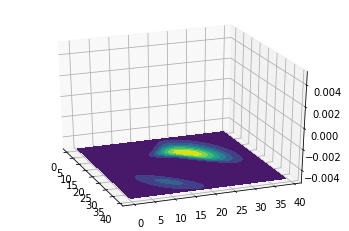

[[16.  3.]
 [14.  2.]
 [15.  2.]
 [15.  4.]
 [14.  4.]
 [16.  2.]
 [16.  4.]
 [15.  3.]
 [14.  3.]]
[0.00011455620886382105, 4.3691186330918955e-05, 6.824400530245668e-05, 3.7884291079449266e-05, 1.3048669243924646e-05, 0.00013916340576820203, 0.00012547929078649637, 4.225264720677259e-05, 2.0772039430177748e-05]
5
normalization factor:  0.9843481126141211
iteration 60 [16.  2.]


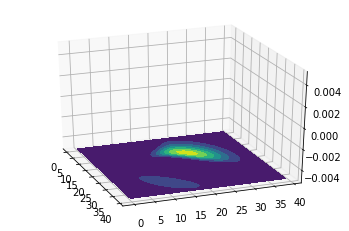

[[17.  2.]
 [16.  2.]
 [17.  1.]
 [15.  2.]
 [16.  1.]
 [15.  3.]
 [15.  1.]
 [16.  3.]
 [17.  3.]]
[9.3455799323824e-05, 3.533333710200473e-05, 0.00011166375778312879, 1.7873729325046234e-05, 5.615419680551918e-05, 1.1444767628074824e-05, 3.698596725090074e-05, 3.233580845573552e-05, 0.00010447970082524545]
2
normalization factor:  0.987909598660353
iteration 61 [17.  1.]


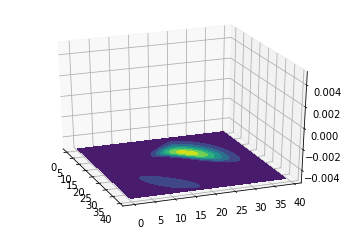

[[16.  2.]
 [17.  0.]
 [17.  1.]
 [16.  1.]
 [18.  0.]
 [18.  2.]
 [18.  1.]
 [17.  2.]
 [16.  0.]]
[9.580985371095543e-06, 1.9881634734412882e-05, 2.8237071447755265e-05, 1.4699366416653483e-05, 4.688951901553543e-05, 8.302741459881856e-05, 7.285620363541396e-05, 2.6340689949911086e-05, 1.1430774852721778e-05]
5
normalization factor:  0.9810964277429313
iteration 62 [18.  2.]


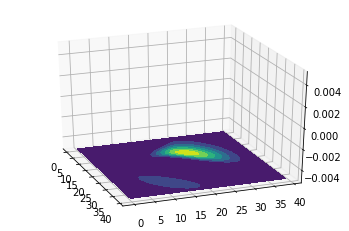

[[17.  1.]
 [18.  1.]
 [19.  1.]
 [19.  2.]
 [17.  2.]
 [18.  2.]
 [17.  3.]
 [18.  3.]
 [19.  3.]]
[8.436774529906943e-06, 2.1025379512846363e-05, 6.234922528704298e-05, 7.28687714844845e-05, 6.523986171268122e-06, 2.130038855629088e-05, 1.217597771643595e-05, 4.001509926882775e-05, 0.00012485003796665881]
8
normalization factor:  0.9716539494905214
iteration 63 [19.  3.]


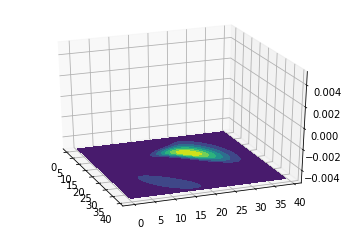

[[19.  3.]
 [20.  2.]
 [18.  2.]
 [20.  3.]
 [19.  2.]
 [20.  4.]
 [19.  4.]
 [18.  4.]
 [18.  3.]]
[3.2406727741465344e-05, 7.087943359974633e-05, 5.674971769358681e-06, 0.0001057732583217281, 2.0184896064167306e-05, 0.00022167051320158882, 8.588369269178085e-05, 3.283833262377154e-05, 9.94315149188596e-06]
5
normalization factor:  0.9603092739109704
iteration 64 [20.  4.]


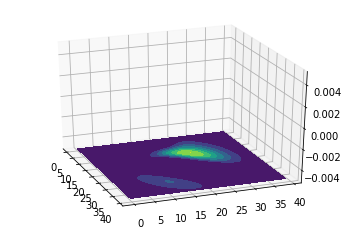

[[19.  4.]
 [20.  5.]
 [21.  5.]
 [19.  5.]
 [21.  4.]
 [20.  4.]
 [20.  3.]
 [19.  3.]
 [21.  3.]]
[2.2105048003986205e-05, 0.0001738163972196531, 0.00037074814555596193, 8.653963469870782e-05, 0.00016464861841450557, 5.815112717506692e-05, 2.8734355550323375e-05, 8.286915568096229e-06, 9.81449403606276e-05]
2
normalization factor:  0.9482260727501177
iteration 65 [21.  5.]


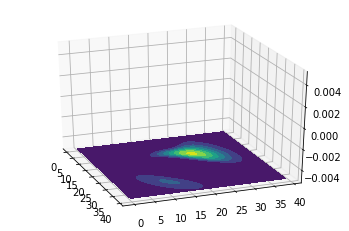

[[20.  4.]
 [20.  5.]
 [20.  6.]
 [22.  4.]
 [21.  4.]
 [22.  5.]
 [21.  6.]
 [21.  5.]
 [22.  6.]]
[1.4999755718788087e-05, 4.660903145219281e-05, 0.00018577568920155523, 0.00013966930472449583, 4.464557970679688e-05, 0.00024284857421542563, 0.00029996270276890625, 9.831728778813794e-05, 0.0005519254081808498]
8
normalization factor:  0.9365901882083503
iteration 66 [22.  6.]


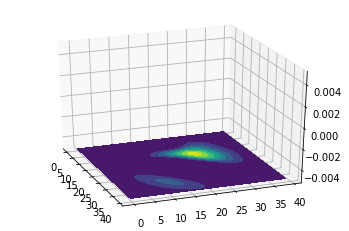

[[23.  7.]
 [21.  7.]
 [22.  5.]
 [21.  6.]
 [21.  5.]
 [23.  5.]
 [22.  6.]
 [22.  7.]
 [23.  6.]]
[0.0007383907862335336, 0.0003198349282733646, 6.633178574660739e-05, 8.343454663300924e-05, 2.6025510946692104e-05, 0.0001903901155010244, 0.00014795488304033595, 0.0004429255899726242, 0.00032985933364917746]
0
normalization factor:  0.926264819484505
iteration 67 [23.  7.]


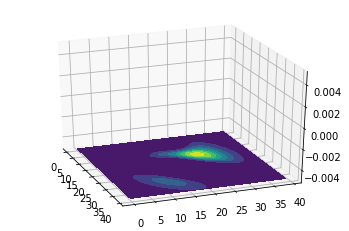

[[24.  6.]
 [23.  7.]
 [23.  6.]
 [22.  6.]
 [23.  8.]
 [24.  7.]
 [24.  8.]
 [22.  8.]
 [22.  7.]]
[0.00024473818431278513, 0.000199930921025788, 9.106444672098362e-05, 4.024281730144918e-05, 0.0005816382903266114, 0.0004165079725776761, 0.0009131398865734569, 0.00046134100297393445, 0.0001266658745003734]
6
normalization factor:  0.917746813745833
iteration 68 [24.  8.]


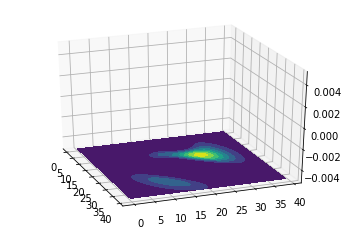

[[25.  9.]
 [24.  7.]
 [25.  7.]
 [24.  8.]
 [25.  8.]
 [23.  7.]
 [24.  9.]
 [23.  9.]
 [23.  8.]]
[0.001068873204317539, 0.00011621538669442714, 0.0002982395100769197, 0.00024935183783936904, 0.0004972222338339544, 5.559360763769643e-05, 0.0007066551607306398, 0.0005909617289497802, 0.00016953006373926523]
0
normalization factor:  0.9113349317323943
iteration 69 [25.  9.]


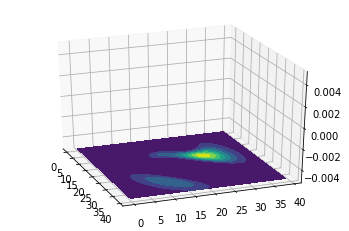

[[26.  8.]
 [24.  8.]
 [24.  9.]
 [25. 10.]
 [26.  9.]
 [26. 10.]
 [24. 10.]
 [25.  8.]
 [25.  9.]]
[0.00034729813414551713, 7.045106947784455e-05, 0.00020856304275202023, 0.0008148131131481935, 0.0005677199260328358, 0.0011992739072373161, 0.0007036420948768636, 0.00013996938093378063, 0.00029375972127722305]
5
normalization factor:  0.90730238177456
iteration 70 [26. 10.]


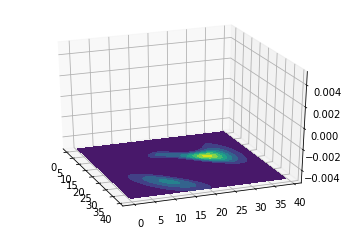

[[25. 11.]
 [27. 11.]
 [25. 10.]
 [26. 10.]
 [27.  9.]
 [25.  9.]
 [26.  9.]
 [27. 10.]
 [26. 11.]]
[0.0007982344892627983, 0.0012945979671500757, 0.00024242225021710122, 0.00033089706106327886, 0.0003880837003856294, 8.390007100475177e-05, 0.00016081513730466118, 0.0006227244285199737, 0.0009014487882153306]
1
normalization factor:  0.905954220555362
iteration 71 [27. 11.]


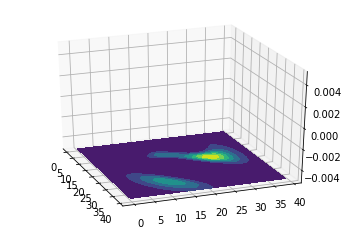

[[26. 11.]
 [27. 10.]
 [26. 10.]
 [28. 11.]
 [26. 12.]
 [27. 12.]
 [28. 10.]
 [28. 12.]
 [27. 11.]]
[0.0002694231896297758, 0.00017696152533615246, 9.51405755716458e-05, 0.0006559966443044744, 0.0008699694815845136, 0.0009585707187004924, 0.0004162047482938761, 0.0013431675188472871, 0.00035756530520415997]
7
normalization factor:  0.9075654292941243
iteration 72 [28. 12.]


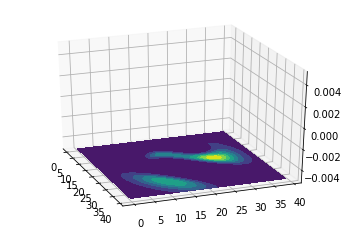

[[27. 13.]
 [28. 11.]
 [27. 12.]
 [28. 13.]
 [27. 11.]
 [29. 13.]
 [29. 12.]
 [28. 12.]
 [29. 11.]]
[0.0009104780697537387, 0.00018639506300800754, 0.0002868810210756795, 0.0009774117532469172, 0.00010312354399987987, 0.0013354059482025367, 0.0006619777184904204, 0.00037016003718061955, 0.0004274634653172405]
5
normalization factor:  0.9122506722257857
iteration 73 [29. 13.]


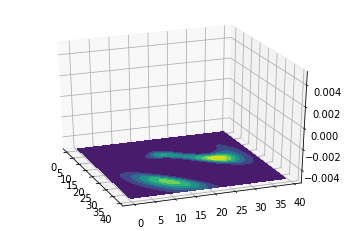

[[30. 12.]
 [30. 13.]
 [29. 14.]
 [29. 13.]
 [29. 12.]
 [28. 14.]
 [30. 14.]
 [28. 12.]
 [28. 13.]]
[0.0004191374976477973, 0.0006378191552004838, 0.0009522043441687311, 0.00036597793553914856, 0.00018743669248912146, 0.0009116355883670631, 0.0012678639369812505, 0.0001067197913679638, 0.0002919773948691455]
6
normalization factor:  0.9198307072571027
iteration 74 [30. 14.]


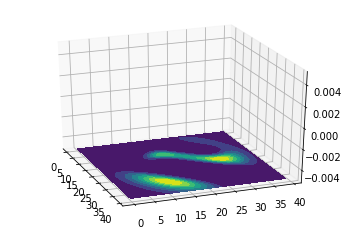

[[29. 13.]
 [31. 13.]
 [30. 15.]
 [30. 14.]
 [29. 15.]
 [31. 14.]
 [31. 15.]
 [29. 14.]
 [30. 13.]]
[0.00010515500279665788, 0.0003911472324850967, 0.0008832253358830044, 0.00034446561711403095, 0.0008697872421745763, 0.0005849145963825956, 0.00114577486073256, 0.0002830721763120175, 0.00017940376225659445]
6
normalization factor:  0.9297614942137652
iteration 75 [31. 15.]


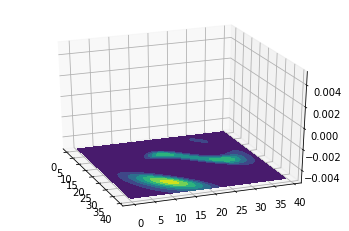

[[30. 14.]
 [32. 15.]
 [31. 14.]
 [30. 15.]
 [31. 15.]
 [32. 16.]
 [31. 16.]
 [32. 14.]
 [30. 16.]]
[9.839979176995796e-05, 0.0005092665099901149, 0.00016303646936687181, 0.0002606738157397722, 0.00030785101416009615, 0.0009830972444243064, 0.0007779272390186223, 0.00034656058439542993, 0.0007883065708721883]
5
normalization factor:  0.9411765821936486
iteration 76 [32. 16.]


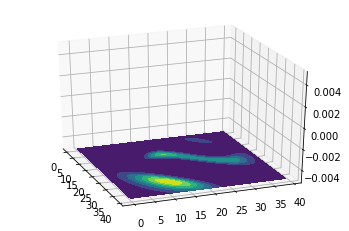

[[32. 16.]
 [31. 16.]
 [32. 15.]
 [32. 17.]
 [33. 16.]
 [33. 15.]
 [33. 17.]
 [31. 15.]
 [31. 17.]]
[0.00026084117928429134, 0.00022761683577716895, 0.00014046455133039665, 0.0006496154737791115, 0.0004203533505338855, 0.00029109596028319346, 0.0007996843541670855, 8.730576150399087e-05, 0.0006774734575280595]
6
normalization factor:  0.9530460133437503
iteration 77 [33. 17.]


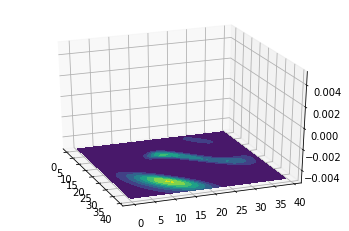

[[33. 18.]
 [34. 16.]
 [32. 16.]
 [32. 18.]
 [32. 17.]
 [33. 17.]
 [34. 18.]
 [33. 16.]
 [34. 17.]]
[0.0005141228435633285, 0.00023172287621168054, 7.341770374620722e-05, 0.0005518318271027415, 0.00018837628827736037, 0.0002094593088554234, 0.0006164818858582576, 0.0001146910653192331, 0.0003288190404307534]
6
normalization factor:  0.9643880460640462
iteration 78 [34. 18.]


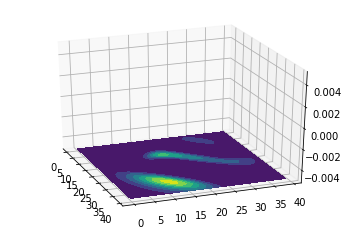

[[35. 18.]
 [35. 17.]
 [33. 18.]
 [34. 17.]
 [34. 18.]
 [35. 19.]
 [33. 19.]
 [33. 17.]
 [34. 19.]]
[0.0002439375370995586, 0.0001749379577199574, 0.00014785992156068998, 8.881324241049289e-05, 0.00015951953311215149, 0.00045072037680675463, 0.00042630991250072346, 5.855447240894931e-05, 0.0003858975520897766]
5
normalization factor:  0.9744350811836736
iteration 79 [35. 19.]


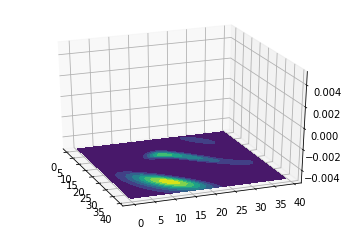

[[36. 20.]
 [34. 20.]
 [34. 19.]
 [35. 18.]
 [35. 20.]
 [34. 18.]
 [36. 18.]
 [36. 19.]
 [35. 19.]]
[0.0003129821843269558, 0.00031280942695498807, 0.00011023224061316668, 6.532048213664351e-05, 0.0002751120841334653, 4.4356150977563507e-05, 0.00012543559738865565, 0.00017187741422567088, 0.00011538688904311286]
0
normalization factor:  0.9826992212487842
iteration 80 [36. 20.]


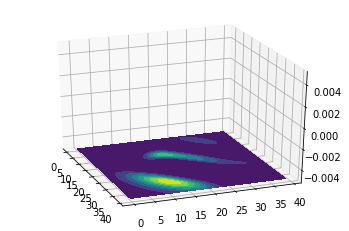

[[35. 20.]
 [37. 20.]
 [36. 21.]
 [37. 19.]
 [36. 20.]
 [35. 19.]
 [37. 21.]
 [35. 21.]
 [36. 19.]]
[7.82048537256446e-05, 0.00011524326638523935, 0.00018664794131175745, 8.558850349585187e-05, 7.942633362771196e-05, 3.197533385073783e-05, 0.00020682496772460538, 0.0002184270840570995, 4.571726772973141e-05]
7
normalization factor:  0.98383318599009
iteration 81 [35. 21.]


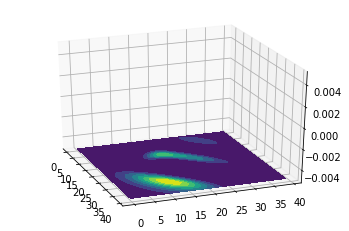

[[34. 20.]
 [35. 20.]
 [36. 22.]
 [36. 21.]
 [36. 20.]
 [35. 22.]
 [35. 21.]
 [34. 22.]
 [34. 21.]]
[3.6785661357854814e-05, 1.9491180552294917e-05, 0.0001424155677585323, 5.329245506633494e-05, 2.3652224228243517e-05, 0.00016449817258249342, 5.573579889110725e-05, 0.0002610923841818343, 0.00010194976749050231]
7
normalization factor:  0.9857854871495059
iteration 82 [34. 22.]


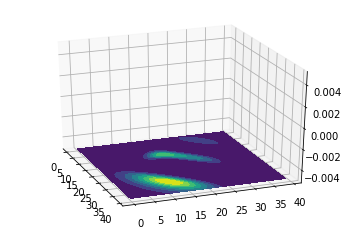

[[34. 22.]
 [33. 21.]
 [35. 22.]
 [34. 23.]
 [33. 23.]
 [33. 22.]
 [34. 21.]
 [35. 21.]
 [35. 23.]]
[6.64251314297897e-05, 7.601685725265772e-05, 4.496584818338767e-05, 0.00016833256565939016, 0.00027888823281499507, 0.00015028122446725435, 2.5285996397893284e-05, 1.4739449756340356e-05, 0.00013164878295680532]
4
normalization factor:  0.989028649076835
iteration 83 [33. 23.]


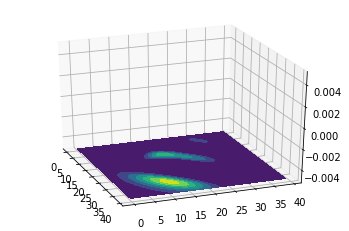

[[33. 23.]
 [32. 24.]
 [32. 23.]
 [32. 22.]
 [33. 22.]
 [34. 23.]
 [34. 24.]
 [34. 22.]
 [33. 24.]]
[7.031626534565918e-05, 0.00018978322407600426, 0.00015090624026707473, 0.0001192979952747793, 3.859237139637438e-05, 4.515316130963508e-05, 0.00011238056900757834, 1.697136463154561e-05, 0.00013083226346066612]
1
normalization factor:  0.9925311265956891
iteration 84 [32. 24.]


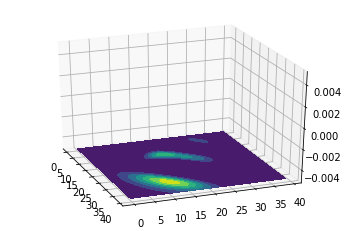

[[32. 25.]
 [33. 23.]
 [32. 24.]
 [32. 23.]
 [33. 25.]
 [31. 24.]
 [33. 24.]
 [31. 25.]
 [31. 23.]]
[6.131062395946085e-05, 1.8534660647425843e-05, 4.7419057532083347e-05, 4.0959826783478905e-05, 6.63665906547809e-05, 8.395708139417162e-05, 3.530943868165762e-05, 7.039712088651638e-05, 0.00010709255231764093]
8
normalization factor:  0.9922789006438979
iteration 85 [31. 23.]


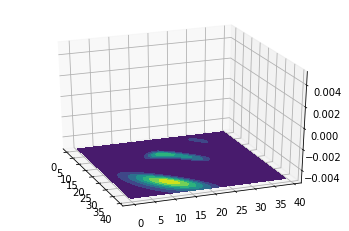

[[31. 22.]
 [30. 23.]
 [31. 23.]
 [32. 24.]
 [32. 23.]
 [32. 22.]
 [31. 24.]
 [30. 24.]
 [30. 22.]]
[4.0703063575724444e-05, 7.129687649690814e-05, 2.699062830823552e-05, 1.4327533265536177e-05, 1.0166865607492176e-05, 1.153653231097485e-05, 2.29326396741748e-05, 4.296406227273576e-05, 0.00012658763965171143]
8
normalization factor:  0.9906949564418116
iteration 86 [30. 22.]


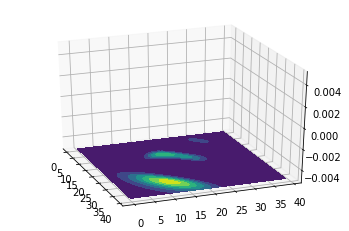

[[30. 23.]
 [29. 23.]
 [31. 22.]
 [29. 21.]
 [31. 21.]
 [31. 23.]
 [29. 22.]
 [30. 21.]
 [30. 22.]]
[1.8580887415209725e-05, 4.4077581855483125e-05, 9.789860558579997e-06, 0.00018322099160092298, 1.746815547818121e-05, 7.099191585006531e-06, 9.023534152998963e-05, 6.163400902580437e-05, 3.207879568788348e-05]
3
normalization factor:  0.9886796062981409
iteration 87 [29. 21.]


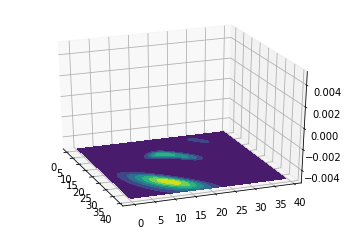

[[28. 21.]
 [30. 20.]
 [30. 22.]
 [29. 20.]
 [28. 22.]
 [29. 21.]
 [30. 21.]
 [29. 22.]
 [28. 20.]]
[0.00012419902770803023, 2.9673457797453943e-05, 7.958321093425886e-06, 9.521049955572158e-05, 5.59706462487349e-05, 4.652250692328638e-05, 1.4882722831537936e-05, 2.3004602727006287e-05, 0.0002603697388375359]
8
normalization factor:  0.9866325714322786
iteration 88 [28. 20.]


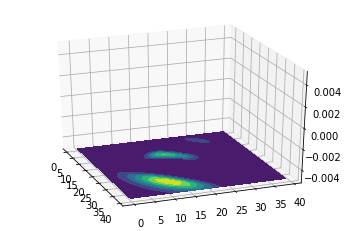

[[27. 19.]
 [27. 20.]
 [29. 20.]
 [28. 19.]
 [27. 21.]
 [28. 20.]
 [29. 19.]
 [29. 21.]
 [28. 21.]]
[0.00034163513523820954, 0.00016448631252769593, 2.3205293935646523e-05, 0.00013471092110354016, 7.31378769753035e-05, 6.614429380978811e-05, 4.622010069350925e-05, 1.1420633722699575e-05, 3.143177003410158e-05]
0
normalization factor:  0.9846789321240557
iteration 89 [27. 19.]


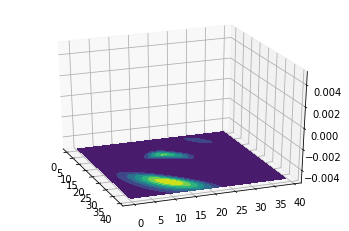

[[26. 18.]
 [26. 20.]
 [27. 19.]
 [26. 19.]
 [28. 19.]
 [28. 20.]
 [27. 18.]
 [28. 18.]
 [27. 20.]]
[0.0004136689574489707, 9.162294915071233e-05, 8.681015971038102e-05, 0.00020333640617173446, 3.3143001870083696e-05, 1.6336315499760775e-05, 0.00017240398221394905, 6.385904925621251e-05, 4.1607448638537416e-05]
0
normalization factor:  0.9827311062393048
iteration 90 [26. 18.]


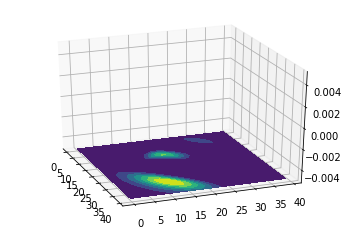

[[27. 17.]
 [25. 18.]
 [27. 18.]
 [26. 19.]
 [25. 17.]
 [25. 19.]
 [26. 18.]
 [26. 17.]
 [27. 19.]]
[7.95003746920886e-05, 0.0002366907717689034, 4.2766759292469275e-05, 5.156627106808075e-05, 0.00047208600482995765, 0.00010869033964432905, 0.00010518185234051847, 0.00020352622590839818, 2.1673890915025277e-05]
4
normalization factor:  0.9805979957197639
iteration 91 [25. 17.]


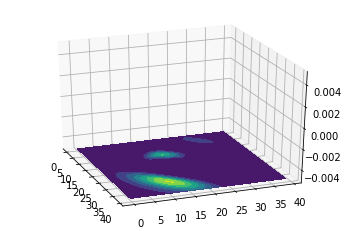

[[26. 16.]
 [25. 18.]
 [25. 17.]
 [26. 17.]
 [24. 18.]
 [25. 16.]
 [26. 18.]
 [24. 17.]
 [24. 16.]]
[9.175820433116967e-05, 6.0248372105434664e-05, 0.00012019778795422871, 5.082454920156174e-05, 0.0001239677638642056, 0.0002276218094290433, 2.6542426600262844e-05, 0.0002656891643567331, 0.0005211992290512995]
8
normalization factor:  0.9781878874257507
iteration 92 [24. 16.]


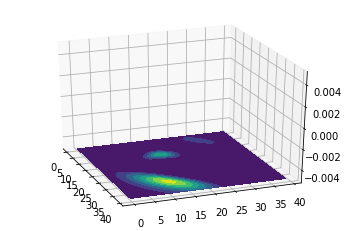

[[25. 16.]
 [23. 15.]
 [24. 15.]
 [24. 16.]
 [25. 15.]
 [23. 16.]
 [25. 17.]
 [24. 17.]
 [23. 17.]]
[5.71327620917664e-05, 0.0005705198453305524, 0.00024701392678237163, 0.00013298259459479833, 0.0001007959805375705, 0.0002960446574247659, 3.059521837090858e-05, 6.790759278781832e-05, 0.00013990906429351918]
1
normalization factor:  0.9757936981655837
iteration 93 [23. 15.]


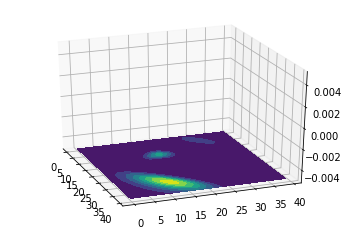

[[23. 15.]
 [23. 16.]
 [22. 15.]
 [24. 16.]
 [24. 14.]
 [22. 16.]
 [23. 14.]
 [22. 14.]
 [24. 15.]]
[0.00014592583116438293, 7.599072844286155e-05, 0.0003366214176540599, 3.4053635885118236e-05, 0.0001073560221942435, 0.00016196337980509844, 0.00026454704772383396, 0.0006294602872228244, 6.220263400076394e-05]
7
normalization factor:  0.9743112028666091
iteration 94 [22. 14.]


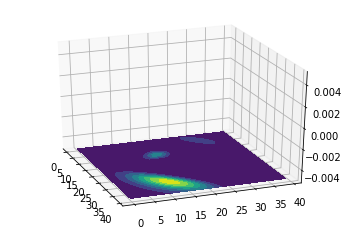

[[22. 14.]
 [21. 13.]
 [23. 13.]
 [23. 14.]
 [21. 15.]
 [23. 15.]
 [22. 13.]
 [22. 15.]
 [21. 14.]]
[0.0001612683792437455, 0.0006956876664025665, 0.00011173244286246749, 6.66482190177409e-05, 0.0001987178584297178, 3.748055132680497e-05, 0.0002803989695775802, 8.680716146853126e-05, 0.00039556220988531265]
1
normalization factor:  0.9750280457722247
iteration 95 [21. 13.]


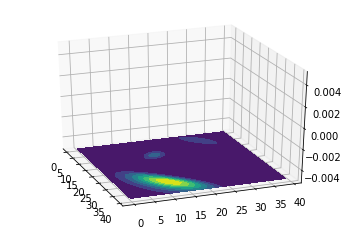

[[20. 12.]
 [22. 12.]
 [22. 13.]
 [20. 14.]
 [22. 14.]
 [21. 14.]
 [21. 12.]
 [21. 13.]
 [20. 13.]]
[0.0007332879936609648, 0.00011250485774298602, 7.04045907744709e-05, 0.0002592857609655444, 4.144123851373062e-05, 0.00010263008104805401, 0.0002868275951525858, 0.00017806184015454546, 0.00046733550856960563]
0
normalization factor:  0.978713335140329
iteration 96 [20. 12.]


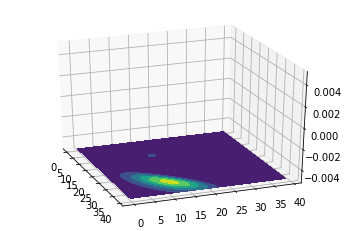

[[20. 12.]
 [21. 11.]
 [19. 12.]
 [19. 11.]
 [21. 13.]
 [19. 13.]
 [20. 13.]
 [21. 12.]
 [20. 11.]]
[0.00018675771177677504, 0.00010541410107588046, 0.0005079731208128116, 0.0006657764191574905, 4.581932819603779e-05, 0.0003380155579645929, 0.00012257860436105963, 7.154301285231097e-05, 0.0002648151566144501]
3
normalization factor:  0.9845902977712631
iteration 97 [19. 11.]


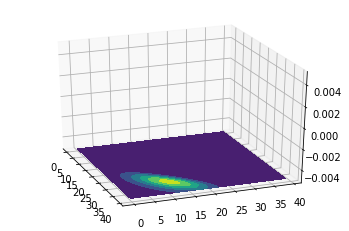

[[20. 12.]
 [18. 10.]
 [18. 12.]
 [20. 10.]
 [20. 11.]
 [19. 11.]
 [19. 10.]
 [19. 12.]
 [18. 11.]]
[4.8527847406167594e-05, 0.00045352188832195237, 0.00038388995447678797, 8.525411418509457e-05, 6.56403547252052e-05, 0.0001681880472567994, 0.0001980209490539709, 0.00013609978419938952, 0.0004411415455063672]
1
normalization factor:  0.9905805291715889
iteration 98 [18. 10.]


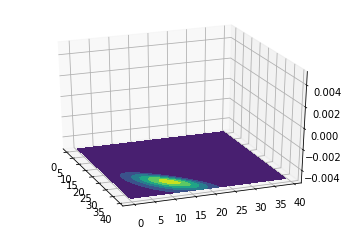

[[19.  9.]
 [18. 11.]
 [19. 11.]
 [18.  9.]
 [17.  9.]
 [17. 10.]
 [19. 10.]
 [17. 11.]
 [18. 10.]]
[5.3677762069341796e-05, 0.00012241555369991698, 4.4879753929443136e-05, 0.00010564338537358075, 0.00020192193707645217, 0.00026182635634071306, 4.9108005505059073e-05, 0.0003190417789182391, 0.00011361316936562809]
7
normalization factor:  0.9934817493448672
iteration 99 [17. 11.]


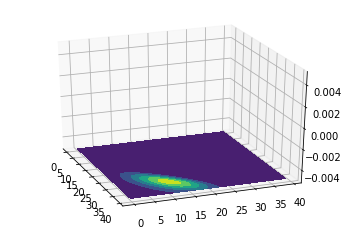

In [82]:
# Initialize variables and parameters
print('-------------------------------------------------\n');
print('> One agent search 2D (greedy 1-step ahead)\n')

# Initialize Agent
agent_state = [15,15]
possible_moves = np.array([[-1., -1.], [-1., 0.], [-1., 1.], [0., -1.], [0., 0.], [0., 1.], [1., -1.], [1., 0.], [1., 1.]])

# Initialize Prior belief
beliefs = np.zeros((40,40))
for i in range(width):
    for j in range(height):
        beliefs[i,j] = bivariate_gaussian([i,j], mu, Sigma)

#Write the function that makes the agent search the environmnet

def agent_search(agent_state, belief, iterations):

    nite = iterations # Number of steps computed
    ite = 0  # Current iteration
    found = 0 # Not used in this code

    while (not found and ite < nite):
        # compute discrete forward states
        # compute utility function of the potential forward states brute force method
        # selection of action/state with max information gain
        move = next_best_state(possible_moves, agent_state, belief)
        
        # simulate agent movement
        agent_state = move
        
        # update belief with the new observation (non-detection)
        prior = belief 
        updated_belief = np.zeros((width,height))
        
        for i in range(len(updated_belief)):
            for j in range(len(updated_belief)):
                updated_belief[i,j] = prior[i,j] * sensor_pnd(Pdmax, dmax, sigma, agent_state, i, j)
        
        # normalize belief
        norm_factor = sum(sum(updated_belief)) # maybe fix?
        print('normalization factor: ', norm_factor)
        normalized_map = updated_belief/norm_factor
        belief = normalized_map
        
        print('iteration {}'.format(ite), agent_state)

        # plot belief and trajectory
        a = Agent(0)
        a.next(agent_state)
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
#         ax.plot_surface(X, Y, belief, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
        cset = ax.contourf(X, Y, belief, zdir='z', offset=-0.005, cmap=cm.viridis)

        ax.set_zlim(-0.005,0.005)
        ax.view_init(27, -21)
#         a.plot(ax)
        plt.show()
        plt.pause(0.1) # animation not needed in the jupyter notebook

        # iteration count
        ite +=1

# execute the function agent_search
agent_search(agent_state, beliefs, 100)